# Symantic Classification of Urban Settlements
## Mort Canty
## November, 2021

## Context
 
[Fully convolutional neural networks](https://ieeexplore.ieee.org/document/7478072) (FCNs) are useful for object recognition and semantic image classification. In this notebook we examine a popular FCN architecture, called [UNet](https://arxiv.org/abs/1505.04597), for urban building recognition (houses, commercial edifices, etc.) in aerial or satellite imagery. [Here](https://arxiv.org/abs/2107.12283) for example is a very recent application of the UNet architecture for large scale semantic classification of building footprints over the entire African continent.  

To train our model we will make use of the dataset  for the [INRIA Aerial Imaging Labeling Benchmark](https://hal.inria.fr/hal-01468452/document), published in 2016. The dataset, consisting of images and semantic labels, can be downloaded [here](https://project.inria.fr/aerialimagelabeling/), and a presentation of the most successful sematic classifiers determined in the early part of the benchmark competition is given [here](https://hal.inria.fr/hal-01767807/document). 


 
After programming and training a UNet network at a **fourfold reduced spatial resolution** to that used in the competition, we'll try to apply it to images outside the INRIA training/test domain by classifying remote sensing images taken from the Google Earth Engine archive.

## Preliminaries

In [ ]:
import ee

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=AisTqtGNeN1-jTRPRksu9np4lsNr2QMyD6qemUuTf-8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgD2Bqdty4VQ1mUnC-zcQziNIUZ173BtxZf6rY4aKWjAnGeoThdeoM

Successfully saved authorization token.


In [ ]:
# Initialize the library.
ee.Initialize()

In [ ]:
# Import python modules
import numpy as np
import scipy
from PIL import Image
import os, sys
from osgeo import gdal,gdalconst
from osgeo.gdalconst import GA_ReadOnly
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
%matplotlib inline

In [ ]:
# Import the Folium library.
import folium
from folium.plugins import Fullscreen # won't work on Colab

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Colab only
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# query GPU device
tf.test.gpu_device_name()

'/device:GPU:0'

## The training Dataset

To quote from the INRIA download site:

 _[the images] cover dissimilar urban settlements, ranging from densely populated areas (e.g., San Francisco’s financial district) to alpine towns (e.g,. Lienz in Austrian Tyrol)-_

There are 180 image/label pairs in all. Here is is an example of a full $5000\times 5000$-pixel image/label pair over Chicago after upload to GEE and projection onto a folium map. For comparison and for later use we also display the corresponding spatial subset of the GEE's [USDA NAIP dataset](https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ). Note the poorer spatial resolution of the NAIP image (circa 1m) relative to the INRIA image (30cm).

In [ ]:
img = ee.Image('projects/ee-shahmanishr01/assets/chicago3')
label = ee.Image('projects/ee-shahmanishr01/assets/chicago_label3')
img_rgb = ee.Image.rgb(img.select(0),img.select(1),img.select(2))

location = img.geometry().centroid().coordinates().getInfo()[::-1]
m = folium.Map(location=location, zoom_start=15, height=800, width=1000)

m.add_ee_layer(img_rgb, {'min': 0, 'max': 200}, 'INRIA Train Image')
m.add_ee_layer(label, {'min': 0, 'max': 200}, 'INRIA Label Image')

naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .select(['R','G','B']) \
                      .filter(ee.Filter.date('2015-01-01', '2015-12-31')) \
                      .filterBounds(img.geometry()) \
                      .mosaic() \
                      .clip(img.geometry()) 

naip_rgb = ee.Image.rgb(naip.select(0),naip.select(1),naip.select(2))
m.add_ee_layer(naip, {'min': 0, 'max': 255}, 'NAIP Image')

m.add_child(folium.LayerControl())

display(m)

**Note: The following cells should be run on the user's local machine, especially if disk space is a problem on Google Drive. The INRIA training data occupy 13 GB before compression but only about 1.5 GB when compressed and augmented (see below). We'll assume that the train images are in the directory _train_folder/images_ and the labels in the diretory _train_folder/gt_.**

In [ ]:
# local only (insert your path here)
train_folder = '/content/drive/MyDrive/train_folder_NOAA/images/train'

### Numpy arrays for training and testing

The following function (somewhat wastefully) clips the original $5000\times 5000$ pixel images and labels to $4096\times 4096$ and then compresses the result to $1024\times 1024$, thus generating training and test image sets with approx 1.2m ground resolution. Each image (and its label) is then split into four $512\times 512$ segments.  There are 720 image/label pairs, which are then augmented by  (1) by applying a linear 2% saturation stretch, (2) a histogram equalization and (3) horizontal flips. This is a so-called *regularization* measure which, it is hoped, will prevent overfitting and improve generalization. The image and label segments are shuffled randomly and the resulting numpy arrays are saved in compressed .npz format to the train_folder directory. This results in 2880 images altogether, of which 400 are split off for testing and validation.

In [ ]:
def bytestretch(arr,rng=None):
#   byte stretch image numpy array
    shp = arr.shape
    arr = arr.ravel()
    if rng is None:
        rng = [np.min(arr),np.max(arr)]
    tmp =  (arr-rng[0])*255.0/(rng[1]-rng[0])
    tmp = np.where(tmp<0,0,tmp)  
    tmp = np.where(tmp>255,255,tmp) 
    return np.asarray(np.reshape(tmp,shp),np.uint8)

def histeqstr(x):
#   histogram equalization stretch        
    x = bytestretch(x)
    hist,bin_edges = np.histogram(x,256,(0,256))
    cdf = hist.cumsum()
    lut = 255*cdf/float(cdf[-1])
    return np.interp(x,bin_edges[:-1],lut)

def lin2pcstr(x):
#  2% linear stretch
    x = bytestretch(x)
    hist,bin_edges = np.histogram(x,256,(0,256))
    cdf = hist.cumsum()
    lower = 0
    i = 0
    while cdf[i] < 0.02*cdf[-1]:
        lower += 1
        i += 1
    upper = 255
    i = 255
    while (cdf[i] > 0.98*cdf[-1]) and (upper>100):
        upper -= 1
        i -= 1
    fp = (bin_edges-lower)*255/(upper-lower)
    fp = np.where(bin_edges<=lower,0,fp)
    fp = np.where(bin_edges>=upper,255,fp)
    return np.interp(x,bin_edges,fp)          

def make_traintest_arrays(folder,tmp='tmp.jpg'):

    gdal.AllRegister()
    translate_options = gdal.TranslateOptions(format='JPEG',outputType=gdalconst.GDT_Byte,
                                              resampleAlg='bilinear',
                                              width=1024,height=1024,srcWin=[0,0,4096,4096])
#  images
    files = os.listdir(folder+'/images')
    files.sort()
    num_files = len(files)
    idx = np.random.permutation(range(16*num_files)) 
    images = np.zeros((16*num_files,512,512,3),dtype=np.uint8)
    i = 0
    print('images array:')
    for file in files: 
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        gdal.Translate(tmp,folder+'/images/'+file,options=translate_options)
        img = np.reshape(np.asarray(Image.open(tmp)),(1024,1024,3))
        images[i,:,:,:] =   img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]   
#      augmentation linear saturation stretch 
        img2pc = img*0
        for k in range(3):
            img2pc[:,:,k] = lin2pcstr(img[:,:,k])
        images[i+4,:,:,:] = img2pc[:512,:512,:]
        images[i+5,:,:,:] = img2pc[:512,512:,:]
        images[i+6,:,:,:] = img2pc[512:,:512,:]
        images[i+7,:,:,:] = img2pc[512:,512:,:]
#      augmentation histogram equalization stretch        
        imgheq = img*0
        for k in range(3):
            imgheq[:,:,k] = histeqstr(img[:,:,k])
        images[i+8,:,:,:] = imgheq[:512,:512,:]
        images[i+9,:,:,:] = imgheq[:512,512:,:]
        images[i+10,:,:,:] = imgheq[512:,:512,:]
        images[i+11,:,:,:] = imgheq[512:,512:,:]        
#      augmentation (left to right flip)         
        images[i+12,:,:,:] = np.flip(img[:512,:512,:],1)
        images[i+13,:,:,:] = np.flip(img[:512,512:,:],1)
        images[i+14,:,:,:] = np.flip(img[512:,:512,:],1)
        images[i+15,:,:,:] = np.flip(img[512:,512:,:],1)        
        i += 16
#  shuffle        
    images = images[idx,:,:,:]    
#  labels    
    files = os.listdir(folder+'/gt')
    files.sort()
    labels = np.zeros((16*num_files,512,512,1),dtype=np.float32)
    i = 0
    print('\nlabels array:')
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        gdal.Translate(tmp,folder+'/gt/'+file,options=translate_options)
        img = np.reshape(np.asarray(Image.open(tmp)),(1024,1024,1))
        img = np.where(img>200,1,0)
        labels[i,:,:,:] =   img[:512,:512,:]
        labels[i+1,:,:,:] = img[:512,512:,:]
        labels[i+2,:,:,:] = img[512:,:512,:]
        labels[i+3,:,:,:] = img[512:,512:,:]
#      augmentation        
        labels[i+4,:,:,:] = img[:512,:512,:]
        labels[i+5,:,:,:] = img[:512,512:,:]
        labels[i+6,:,:,:] = img[512:,:512,:]
        labels[i+7,:,:,:] = img[512:,512:,:]
#      augmentation        
        labels[i+8,:,:,:] = img[:512,:512,:]
        labels[i+9,:,:,:] = img[:512,512:,:]
        labels[i+10,:,:,:] = img[512:,:512,:]
        labels[i+11,:,:,:] = img[512:,512:,:]     
#      augmentation (left to right flip)         
        labels[i+12,:,:,:] =   np.flip(img[:512,:512,:],1)
        labels[i+13,:,:,:] = np.flip(img[:512,512:,:],1)
        labels[i+14,:,:,:] = np.flip(img[512:,:512,:],1)
        labels[i+15,:,:,:] = np.flip(img[512:,512:,:],1)  
        i += 16        
#  shuffle        
    labels = labels[idx,:,:,:]   
#  split off test data (400 image/label pairs)   
    split = 16*num_files - 400
    x_train = images[:split,:,:,:]
    y_train = labels[:split,:,:,:]
    x_test = images[split:,:,:,:]
    y_test = labels[split:,:,:,:]
#  save compressed    
    np.savez_compressed(folder+'/images_trainx.npz',x_train=x_train,y_train=y_train)
    np.savez_compressed(folder+'/images_testx.npz',x_test=x_test,y_test=y_test)

In [ ]:
# local only
make_traintest_arrays(train_folder)

In [ ]:
import PIL
print(PIL.__file__)
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [ ]:
#define the image
image_path = '/content/drive/MyDrive/train_folder_NOAA/images/train/images/austin10.tif'
image_loc = plt.imread(image_path)
#plt.imshow(image)

#set image size for the model:
imsize = [512,512]

#pull the image
img = tf.keras.preprocessing.image.load_img(image_path,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)

#make pred
pred = model.predict(img)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(image_loc)
pred = model.predict(tf.reshape(img,(1,512,512,3)))
pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
ax[1].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('predicted')
plt.show()

**Note: The compressed .npz files should now be uploaded  to the folder _Inria_ on the user's Google Drive. What follows is run in Colab with a GPU runtime.**

In [ ]:
# Colab only
train_folder = '/content/drive/MyDrive/train_folder_NOAA/images/train'

In [ ]:
ls -l $train_folder

### Make train and test datasets in RAM
 
There are 2880 image/label pairs in all (the images are $512\times 512\times 3$ RGB cubes in unsigned byte format, the labels are $512\times 512\times 1$ in 32 bit float). They can be kept in memory during training if enough RAM is available using the *tf.data.Dataset.from_tensor_slices()* function. Both the training and test data are batched (batch size 4):

In [ ]:
path = train_folder+'/images_trainx.npz'
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']   
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels)).batch(4)

path = train_folder+'/images_testx.npz'
with np.load(path) as data:
  test_examples = data['x_test']
  test_labels = data['y_test']        
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).batch(4) 

### Make train and test datasets with generator pipeline
Alternatively, if RAM is insufficient, the train/test data can be pipelined using the *tf.data.Dataset.from_generator()* function:

In [ ]:
class MakeDataset():

    def _generator(path):
        with np.load(path) as data:
            train_examples = data['x_train']
            train_labels = data['y_train']
            for index, example in enumerate(train_examples):
                yield (example,train_labels[index])

    def __new__(cls,path):
        return tf.data.Dataset.from_generator( cls._generator,
               output_signature = ( tf.TensorSpec(shape=(512,512,3),dtype=tf.uint8),
               tf.TensorSpec(shape=(512,512,1),dtype=tf.float32) ),
               args = (path,) ).batch(4)

train_dataset = MakeDataset(train_folder+'/images_trainx.npz')

class MakeDataset():

    def _generator(path):
        with np.load(path) as data:
            test_examples = data['x_test']
            test_labels = data['y_test']
            for index, example in enumerate(test_examples):
                yield (example,test_labels[index])

    def __new__(cls,path):
        return tf.data.Dataset.from_generator( cls._generator,
               output_signature = ( tf.TensorSpec(shape=(512,512,3),dtype=tf.uint8),
               tf.TensorSpec(shape=(512,512,1),dtype=tf.float32) ),
               args = (path,) ).batch(4)

test_dataset = MakeDataset(train_folder+'/images_testx.npz')

Here are some examples from a train batch:

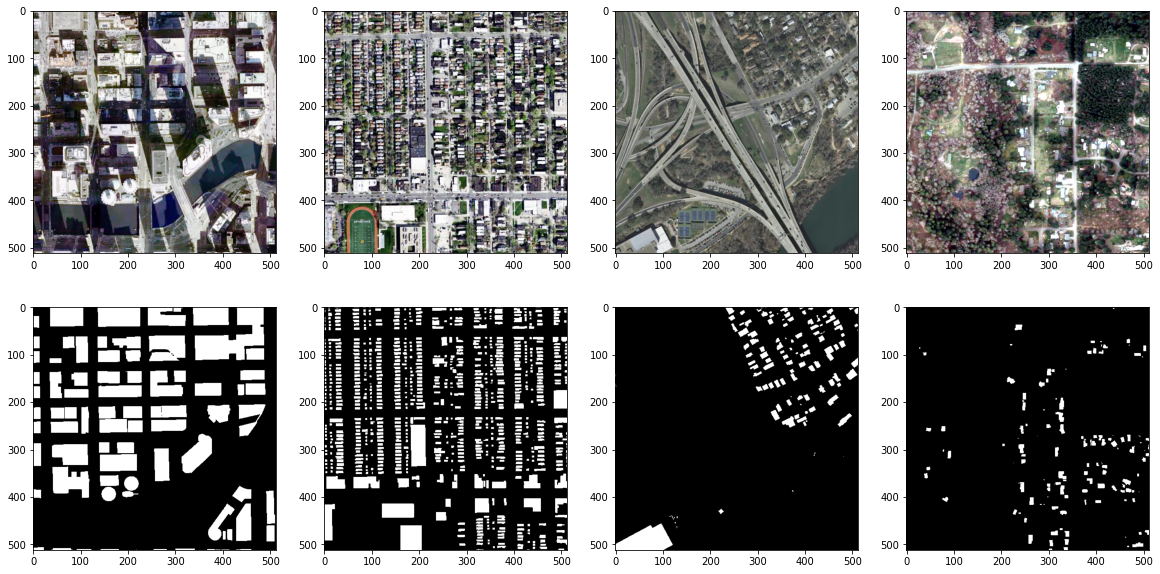

In [ ]:
train_examples, train_labels = next(train_dataset.as_numpy_iterator())
fig, ax = plt.subplots(2,4,figsize=(20,10))
for i in range(4):
    ax[0,i].imshow(train_examples[i])
    ax[1,i].imshow(np.reshape(train_labels[i],(512,512)),cmap = plt.cm.gray)
plt.show()

### The UNet FCN
We'll program here a "vanilla" UNet based on the architecture described in [de Jong et al. (2019)](https://export.arxiv.org/pdf/1812.05815v2). It consists of an encoder and decoder section with lateral connections between the two, which in the literature is usually displayed in the form of a "U". The encoder section is a series of 5 pairs of Conv2D convolutional layers, with successively doubling numbers of filters (64, 128, ...), connected by MaxPooling2D layers which successively halve the image dimensions (512, 256, ...). The decoder section reverses the process with the help of upsampling Conv2DTranspose layers, ultimately reconstructing the input image signal at the network output. The input to each upsampling layer consists of the output from the preceding layer, merged (concatenated) with the output of the corresponding Conv2d layer from the encoding section. The idea is to restore higher resolution details lost during the image compression (encoding) phase while decoding takes place. The model takes as input a three channel RGB image in _np.uint8_ format and outputs an 1-channel image in _np.float32_ format. The output of the last Conv2D layer is passed through a sigmoid activation function.

Since the convolutional layers are all identical except for the number of filters, and since each is followed by a [batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layer, it improves readability to use some shortcut functions. These can be conveniently programmed with the tensorflow _sequential API_:

In [ ]:
# shortcuts
def conv2d(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters,3,padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def conv2dtranspose(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2DTranspose(filters,3,strides=2,padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def maxpooling2d():
    return tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding="same")

Here is the full UNet model written in tensorflow's _functional API_:

In [ ]:
# UNet
def unet_model(num_channels=3,image_size=512):    
    inputs = tf.keras.layers.Input(shape=(image_size,image_size,num_channels))
    rescaled= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#  coder     
    conv11 = conv2d(64)(rescaled)
    conv12 = conv2d(64)(conv11)
    max_pool1 = maxpooling2d()(conv12)
    conv21 = conv2d(128)(max_pool1)
    conv22 = conv2d(128)(conv21)
    max_pool2 = maxpooling2d()(conv22)
    conv31 = conv2d(256)(max_pool2)
    conv32 = conv2d(256)(conv31)
    max_pool3 = maxpooling2d()(conv32)
    conv41 = conv2d(512)(max_pool3)
    conv42 = conv2d(512)(conv41)
    max_pool4 = maxpooling2d()(conv42)
    conv51 = conv2d(1024)(max_pool4)
    conv52 = conv2d(1024)(conv51)
#  decoder    
    uconv51 = conv2dtranspose(512)(conv52)
    merge_dec5 = tf.keras.layers.concatenate([conv42,uconv51],axis=3)
    conv_dec_41 = conv2d(512)(merge_dec5)
    conv_dec_42 = conv2d(512)(conv_dec_41)
    uconv41 = conv2dtranspose(256)(conv_dec_42)
    merge_dec4 = tf.keras.layers.concatenate([conv32,uconv41],axis=3)
    conv_dec_31 = conv2d(256)(merge_dec4)
    conv_dec_32 = conv2d(256)(conv_dec_31)
    uconv31 = conv2dtranspose(128)(conv_dec_32)
    merge_dec3 = tf.keras.layers.concatenate([conv22,uconv31],axis=3)
    conv_dec_21 = conv2d(128)(merge_dec3)
    conv_dec_22 = conv2d(128)(conv_dec_21)
    uconv21 = conv2dtranspose(64)(conv_dec_22)
    merge_dec2 = tf.keras.layers.concatenate([conv12,uconv21],axis=3)
    conv_dec_11 = conv2d(64)(merge_dec2)
    conv_dec_12 = conv2d(64)(conv_dec_11)
#  output    
    conv_dec_12 = conv2d(8)(conv_dec_12)
    output = tf.keras.layers.Conv2D(1,1,activation = 'sigmoid')(conv_dec_12)
    return tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
model = None
model = unet_model()
model.summary()

We'll also use a standard Adam optimizer with a learning rate of 0.001 and a BinaryCrossentropy loss function corresponding to the sigmoid activation. The metric is _BinaryAccuracy()_.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

### Training
During training it is a good idea to include a callback which saves the model after each epoch whenever the training loss (or validation loss if overfitting might be an issue) has been reduced. The Colab notebook's (free) GPU runtime may be disconnected by the provider at any time during training, particularly when the number of epochs is large  and the model state will otherwise be lost. Since training data are scarce, we will use the test data for both validation and testing. 

In [ ]:
# Training
callback = ModelCheckpoint(train_folder+'/firs_tmodel.h5', monitor='loss', save_best_only=True)
history = model.fit(train_dataset, epochs=2, callbacks = [callback], validation_data=test_dataset)

Epoch 1/2
620/620 [==============================] - 776s 1s/step - loss: 0.1648 - binary_accuracy: 0.9337 - val_loss: 0.1443 - val_binary_accuracy: 0.9419
Epoch 2/2
620/620 [==============================] - 765s 1s/step - loss: 0.1443 - binary_accuracy: 0.9422 - val_loss: 0.1371 - val_binary_accuracy: 0.9453


Also the following hint is useful:

In [ ]:
#Run this Javascript snippet in your browser console to prevent getting thrown out prematurely
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

Reload the model if necessary:

In [ ]:
model = keras.models.load_model(train_folder+'/firs_tmodel.h5')

In [ ]:
train_folder = '/content/drive/MyDrive/train_folder_NOAA/images/train'

This changes the learn rate if desired:

In [ ]:
model.optimizer.lr.assign(0.0003)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0003>

### Evaluation
After training for 30 epochs at learn rate 0.001 and 10 epochs at learn rate of 0.0003:

In [ ]:
model.evaluate(test_dataset)

100/100 [==============================] - 150s 1s/step - loss: 0.1371 - binary_accuracy: 0.9453


[0.13705359399318695, 0.9453076124191284]

### Intersection over Union (IoU) test

The comparison metric used inthe INRIA benchmark competition was _intersection over union_ (IoU), referring to the sets of labeled and classified pixels. A value of one implies perfect reproduction of the label image, a value zero means no correpondance whatsoever. The cell below calculates the average IoU for the test image/label pairs (recall that they are stored in memory in batches of 4).

In [ ]:
i = 0
sumIoU = 0
for test_example, test_label in test_dataset:
    for j in range(4):
        label = np.reshape(test_label[j],(512,512))
        example = np.reshape(test_example[j],(1,512,512,3))
        pred = model.predict(example)
        pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
        I = label*pred
        U = label+pred-I
        sU = np.sum(U)
        if sU>0: # buildings in subscene?
            sumIoU += np.sum(I)/sU
            i += 1        
sumIoU/i

0.591868782080126

This excellent result exceeds the best results obtained by [Maggiori et al. (2017)](https://hal.inria.fr/hal-01468452/document) in the initial benchmarking of the INRIA dataset using a multi-label perceptron (MLP) architecture (0.60). The [initial winners](https://hal.inria.fr/hal-01767807/document) of the competition, achieved IoUs of the order 0.7 with variations of the UNet model that we are using here, although later submissions reported as much as 0.8. All of the competition exercises were performed at 30cm spatial resolution, whereas we are training at 1.2m resolution so that a direct comparison may be misleading.

### Visual testing

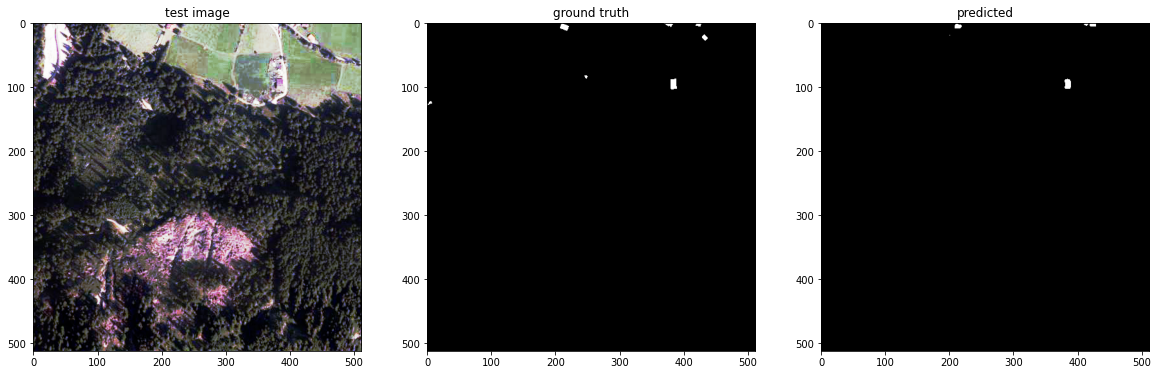

In [ ]:
i = 3
testds = iter(test_dataset)
_, _ = next(testds)
#_, _ = next(testds)
test_example, test_label = next(testds)
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(test_example[i])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,3)))
pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

### New data (NAIP)
Our next goal is to use the UNet model to identify buildings in the NAIP aerial imagery in the GEE archive, which is confined to the continental USA. We will therefore continue training the model with NAIP subsets which match the original training images over American cities, namely Austin (36 scenes) and Chicago (36 scenes). To this end we must first upload the corresponding 72 label images from our local machine to GEE assets, and then export the matching NAIP images (and the labels) to Google Drive at a scale of 1m and with the same crs as the label images. The uploading has, unfortunately, to be done image-for-image from the GEE asset menu. We can take advantage of the fact that the NAIP imagery is acquired repeatedly over several years, so that we can obtain repeated training examples measured at different times and with different sensors.

Here is the export script for downloading the NAIP image/label pairs for 2012. We repeat this for 2015 1nd 2017.

In [ ]:
start = 1
end = 36

#images = ['projects/ee-shahmanishr01labels/assets/austin10'+str(i) for i in range(start,end+1)]
#crs = 'EPSG:26914'
#fnp = 'austin'

images = ['projects/ee-shahmanishr01labels/assets/chicago'+str(i) for i in range(start,end+1)]
crs = 'EPSG:26916'
fnp = 'chicago'

for i in range(start-1,end):
    filenameprefix = fnp+str(i+1)
    lbl = ee.Image(images[i]) # the labels
    naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .select(['R','G','B']) \
                      .filter(ee.Filter.date('2010-01-01', '2012-12-31')) \
                      .filterBounds(lbl.geometry()) \
                      .mosaic() \
                      .clip(lbl.geometry()) 
    gdexport = ee.batch.Export.image.toDrive(naip,
                description='driveExportTask', 
                folder = 'naip_images_2012_chicago',
                crs = crs,                             
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport.start()
    gdexport1 = ee.batch.Export.image.toDrive(lbl,
                description='driveExportTask', 
                folder = 'naip_labels',
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport1.start()    


Now the 1m resolution images and their labels are on Google Drive. After downloading to the local machine, we create the train/test datasets as before in compressed .npz format, including 2% linear stretch and histogram equalization augmentation as well with chaining of the 2015 and 2017 aquisition periods (leaving out the 2012 data as they may differ too much from the labels which were created in 2016):

In [ ]:
def make_traintest_arrays_naip(folder):
    from osgeo.gdalconst import GA_ReadOnly

    gdal.AllRegister()
    
#  images
    files = os.listdir(folder+'/naip_images_2015')
    files.sort()
    num_files = len(files)
    idx = np.random.permutation(range(24*num_files)) 
    images = np.zeros((24*num_files,512,512,3),dtype=np.uint8)
    i = 0
    print('images array 2015:')
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ')         
        img = np.zeros((1024,1024,3),dtype=np.uint8)      
        inDataset = gdal.Open(folder+'/naip_images_2015/'+file, GA_ReadOnly)
        for b in range(3):
            band = inDataset.GetRasterBand(b+1)
            img[:,:,b] = band.ReadAsArray(0,0,1024,1024)        
        images[i,:,:,:] =   img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]   
#      augmentation linear saturation stretch 
        img2pc = img*0
        for k in range(3):
            img2pc[:,:,k] = lin2pcstr(img[:,:,k])
        images[i+4,:,:,:] = img2pc[:512,:512,:]
        images[i+5,:,:,:] = img2pc[:512,512:,:]
        images[i+6,:,:,:] = img2pc[512:,:512,:]
        images[i+7,:,:,:] = img2pc[512:,512:,:]
#      augmentation histogram equalization stretch        
        imgheq = img*0
        for k in range(3):
            imgheq[:,:,k] = histeqstr(img[:,:,k])
        images[i+8,:,:,:] = imgheq[:512,:512,:]
        images[i+9,:,:,:] = imgheq[:512,512:,:]
        images[i+10,:,:,:] = imgheq[512:,:512,:]
        images[i+11,:,:,:] = imgheq[512:,512:,:] 
        i += 12       
    print('\nimages array 2017:')    
    files = os.listdir(folder+'/naip_images_2017')
    files.sort()
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ')          
        inDataset = gdal.Open(folder+'/naip_images_2017/'+file, GA_ReadOnly)
        for b in range(3):
            band = inDataset.GetRasterBand(b+1)
            img[:,:,b] = band.ReadAsArray(0,0,1024,1024)
        images[i,:,:,:] = img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]
#      augmentation linear saturation stretch 
        img2pc = img*0
        for k in range(3):
            img2pc[:,:,k] = lin2pcstr(img[:,:,k])
        images[i+4,:,:,:] = img2pc[:512,:512,:]
        images[i+5,:,:,:] = img2pc[:512,512:,:]
        images[i+6,:,:,:] = img2pc[512:,:512,:]
        images[i+7,:,:,:] = img2pc[512:,512:,:]
#      augmentation histogram equalization stretch        
        imgheq = img*0
        for k in range(3):
            imgheq[:,:,k] = histeqstr(img[:,:,k])
        images[i+8,:,:,:] = imgheq[:512,:512,:]
        images[i+9,:,:,:] = imgheq[:512,512:,:]
        images[i+10,:,:,:] = imgheq[512:,:512,:]
        images[i+11,:,:,:] = imgheq[512:,512:,:] 
        i += 12          
#  shuffle        
    images = images[idx,:,:,:]    
    
#  labels    
    files = os.listdir(folder+'/naip_labels')
    files.sort()
    labels = np.zeros((12*num_files,512,512,1),dtype=np.float32)
    i = 0
    print('\nlabels array:')
    for file in files: 
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        inDataset = gdal.Open(folder+'/naip_labels/'+file, GA_ReadOnly)                              
        band = inDataset.GetRasterBand(1)
        img = np.reshape(band.ReadAsArray(0,0,1024,1024),(1024,1024,1))
        img = np.where(img>200,1,0)       
        labels[i,:,:,:] =   img[:512,:512,:]
        labels[i+1,:,:,:] = img[:512,512:,:]
        labels[i+2,:,:,:] = img[512:,:512,:]
        labels[i+3,:,:,:] = img[512:,512:,:]
        labels[i+4,:,:,:] =  img[:512,:512,:]
        labels[i+5,:,:,:] = img[:512,512:,:]
        labels[i+6,:,:,:] = img[512:,:512,:]
        labels[i+7,:,:,:] = img[512:,512:,:]
        labels[i+8,:,:,:] = img[:512,:512,:]
        labels[i+9,:,:,:] = img[:512,512:,:]
        labels[i+10,:,:,:] = img[512:,:512,:]
        labels[i+11,:,:,:] = img[512:,512:,:]
        i += 12
    labels = np.concatenate((labels,labels))
#  shuffle        
    labels = labels[idx,:,:,:]   
#  split off test data 
    split = 24*num_files - 400
    x_train = images[:split,:,:,:]
    y_train = labels[:split,:,:,:]
    x_test = images[split:,:,:,:]
    y_test = labels[split:,:,:,:]
#  save compressed    
    np.savez_compressed(folder+'/naip_images_trainx.npz',x_train=x_train,y_train=y_train)
    np.savez_compressed(folder+'/naip_images_testx.npz',x_test=x_test,y_test=y_test)

In [ ]:
make_traintest_arrays_naip(train_folder)

Then the .npz files are again uploaded back to the Google Drive and the train/test data read into RAM: 

In [ ]:
train_folder = '/content/drive/MyDrive'

In [ ]:
path = train_folder+'/naip_images_trainx.npz'
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']   
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels)).batch(4)

path = train_folder+'/naip_images_testx.npz'
with np.load(path) as data: 
  test_examples = data['x_test']
  test_labels = data['y_test']        
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).batch(4) 

Next we load inria-trained model:

In [ ]:
model = keras.models.load_model(train_folder+'/firs_tmodel.h5')

In [ ]:
train_folder = '/content/drive/MyDrive/train_folder_NOAA/images/train'

And do some visual testing:

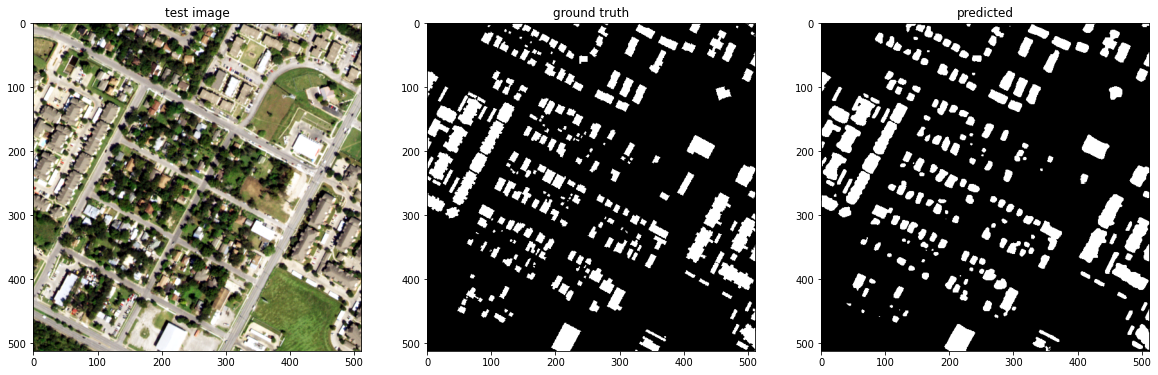

In [ ]:
i = 1
testds = iter(test_dataset)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
test_example, test_label = next(testds)
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(test_example[i])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,3)))
pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

Here is the IoU for the naip images:

In [ ]:
i = 0
sumIoU = 0
for test_example, test_label in test_dataset:
    for j in range(4):
        label = np.reshape(test_label[j],(512,512))
        example = np.reshape(test_example[j],(1,512,512,3))
        pred = model.predict(example)
        pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
        I = label*pred
        U = label+pred-I
        sU = np.sum(U)
        if sU>0: # no buildings in subscene?
            sumIoU += np.sum(I)/sU
            i += 1        
sumIoU/i

0.606168696422047

It is considerably worse than for the inria images, therefore we continue training, saving the model now as _unet_inria_modelxx.h5_:



In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
callback = ModelCheckpoint(train_folder+'/firs_tmodel.h5', monitor='loss', save_best_only=True)
history = model.fit(train_dataset, epochs=10, callbacks = [callback], validation_data=test_dataset)

Epoch 1/10
332/332 [==============================] - 413s 1s/step - loss: 0.1565 - binary_accuracy: 0.9365 - val_loss: 0.2021 - val_binary_accuracy: 0.9207
Epoch 2/10
332/332 [==============================] - 413s 1s/step - loss: 0.1410 - binary_accuracy: 0.9427 - val_loss: 0.1903 - val_binary_accuracy: 0.9266
Epoch 3/10
332/332 [==============================] - 413s 1s/step - loss: 0.1381 - binary_accuracy: 0.9436 - val_loss: 0.1910 - val_binary_accuracy: 0.9256
Epoch 4/10
332/332 [==============================] - 413s 1s/step - loss: 0.1286 - binary_accuracy: 0.9473 - val_loss: 0.1668 - val_binary_accuracy: 0.9361
Epoch 5/10
332/332 [==============================] - 414s 1s/step - loss: 0.1215 - binary_accuracy: 0.9499 - val_loss: 0.1555 - val_binary_accuracy: 0.9407
Epoch 6/10
332/332 [==============================] - 413s 1s/step - loss: 0.1157 - binary_accuracy: 0.9521 - val_loss: 0.1450 - val_binary_accuracy: 0.9425
Epoch 7/10
332/332 [==============================] - 408s

In [ ]:
model = keras.models.load_model(train_folder+'/firs_tmodel.h5')

After training for about 20 epochs, we again do some visual testing:

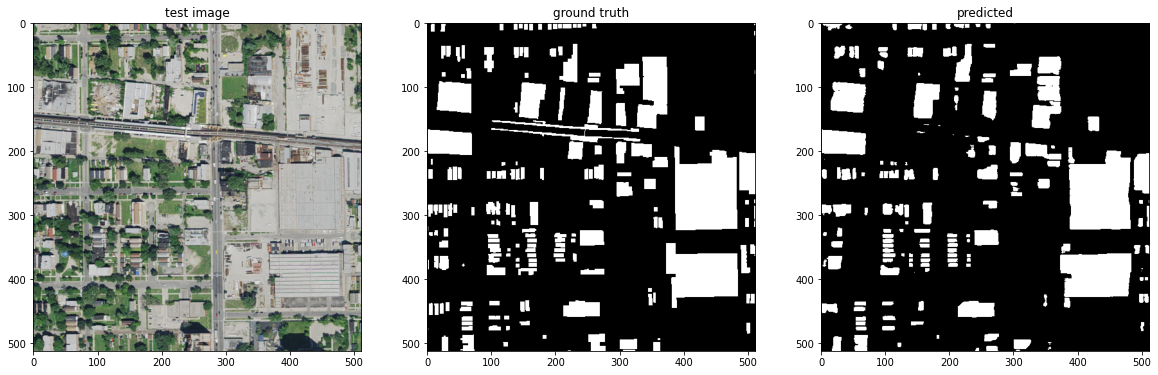

In [ ]:
i = 1
testds = iter(test_dataset)
_, _ = next(testds)
_, _ = next(testds)
_, _ = next(testds)
test_example, test_label = next(testds)
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(test_example[i])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,3)))
pred = np.reshape(np.where(pred>0.6,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

It looks pretty good, but what about IoU for the NAIP test dataset:

In [ ]:
i = 0
sumIoU = 0
for test_example, test_label in test_dataset:
    for j in range(4):
        label = np.reshape(test_label[j],(512,512))
        example = np.reshape(test_example[j],(1,512,512,3))
        pred = model.predict(example)
        pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
        I = label*pred
        U = label+pred-I
        sU = np.sum(U)
        if sU>0: # no buildings in subscene?
            sumIoU += np.sum(I)/sU
            i += 1        
sumIoU/i

0.7169596820691422

In [ ]:
# visualize the first test example in the third batch

i = 1 # example
k = 3 # batch
testds = iter(test_dataset)
for j in range(k-1):
    _, _ = next(testds)
test_example, test_label = next(testds)
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(test_example[i])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,3)))
pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

Now we have regained the good result achieved by the INRIA competition winners! So lets try to classify some new data. The script _unetclassiy.py_ in the _scripts_ directory partitions an input image into $512\times 512$ tiles starting at the upper left hand corner and passes each tile through the trained model to classify it. It loads the pre-trained model and uses the model's _predict()_ function to classify the tiles. Here is the help output:

In [ ]:
%run /content/drive/MyDrive/scripts/unetclassify -h

Here is a NAIP image exported from GEE from 2018 over the Lawrence Livermore Laboratories in California:


In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/livermore2018.tif -p [1,2,3] -e 3 

Classifying:

In [ ]:
%run /content/drive/MyDrive/scripts/unetclassify  -m /content/drive/MyDrive/Inria/unet_inria_modelxx.h5 /content/drive/MyDrive/gee/livermore2018.tif

We predict the labels:

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/livermore2018_cnn.tif  -d [0,0,4000,3000]

After downloading the above two images and then uploading to the EarthEngine, we can overlay them nicely (the images are shared on GEE):

In [ ]:
img = ee.Image('projects/ee-mortcanty/assets/livermore2018')
lab = ee.Image('projects/ee-mortcanty/assets/livermore2018_cnn')

location = ee.Geometry.Polygon(img.get('system:footprint').getInfo()['coordinates']).centroid().getInfo()['coordinates'][::-1]

m = folium.Map(location=location, zoom_start=14, height=800, width=1000)

m.add_ee_layer(img,{'min':0,'max':255},'NAIP')
m.add_ee_layer(lab.updateMask(lab.gt(0)),{'min':0,'max':255,'palette':['black','red']},'Label')

m.add_child(folium.LayerControl())
Fullscreen().add_to(m)

display(m)

EEException: ignored

## Conclusion

With a very straghtforward implementation of the UNet architecture we have obtained a good symantic classifier for building recognition, one which is close to state-of-the-art for the small training datasets available. We have also seen that the classifier can be applied to new RGB imagery from other sensors.